October: This notebook extracts the realistic bathymetry of the domain.

In [21]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from pyproj import Proj, Geod, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colormap_ibcao
from scipy.interpolate import griddata
%matplotlib inline

# Get domain coordinates

In [2]:
filename = 'coords_mack06.nc'
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_coordinates/'+filename)
lon_g = coord_file['nav_lon']
lat_g = coord_file['nav_lat']

def convert_corners(proj_from, proj_to, corner_lons, corner_lats):
    ''' Converts the coordinates of the domain corner points
    from the projection proj_from to the projection proj_to.
    The tranformed coordinates are returned.
    '''
    transformed_lons = []
    transformed_lats = []
    for i in np.arange(len(corner_lons)):
        transformed_x, transformed_y = transform(proj_from, proj_to, corner_lons[i], corner_lats[i])
        transformed_lons.append(transformed_x)
        transformed_lats.append(transformed_y)
    return transformed_lons, transformed_lats

# -----------------------------------------------------------------------------------------------
#lon_geogr = [lon[-1,0], lon[0,0], lon[0,-1], lon[-1,-1]]
#lat_geogr = [lat[-1,0], lat[0,0], lat[0,-1], lat[-1,-1]]

proj_geogr = Proj("+init=EPSG:4326") # Geographical coordinate system
proj_stere = Proj("+init=EPSG:3996") # IBCAO polar stereographic

#lon_stere0, lat_stere0 = convert_corners(proj_geogr, proj_stere, lon_geogr, lat_geogr)
#lon_stere = [round(float(x) / 500) * 500 for x in lon_stere0]
#lat_stere = [round(float(x) / 500) * 500 for x in lat_stere0]
#lonBR = lon_stere[0]; lonTR = lon_stere[1]; lonTL = lon_stere[2]; lonBL = lon_stere[3]
#latBR = lat_stere[0]; latTR = lat_stere[1]; latTL = lat_stere[2]; latBL = lat_stere[3]
#print(min(lon_stere0), lat_stere0)

# -----------------------------------------------------------------------------------------------
lon_s =  np.zeros_like(lon_g)
lat_s =  np.zeros_like(lat_g)
for i in np.arange(lon_g.shape[0]):
    lon_s[i,:], lat_s[i,:] = transform(proj_geogr, proj_stere, lon_g[i,:], lat_g[i,:])

# Get IBCAO bathymetry

In [5]:
bathy_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x = bathy_file.variables['x'][:]
y = bathy_file.variables['y'][:]
z = bathy_file.variables['z'][:]

xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x==xl)[0][0]; xmax = np.where(x==xr)[0][0]
ymin = np.where(y==yb)[0][0]; ymax = np.where(y==yt)[0][0]
xn = x[xmin:xmax]; yn = y[ymin:ymax]; zn = z[ymin:ymax, xmin:xmax]

# Stereographic map with corner points

# Specify domain area

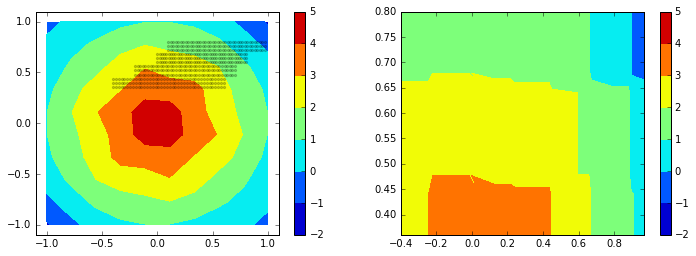

In [25]:
x0 = np.linspace(-1,1,10)
y0 =  np.linspace(-1,1,10)
X_full, Y_full = np.meshgrid(x0, y0)
Z_full = f(X_full, Y_full)

z_full = Z_full.ravel()
x_full = X_full.ravel()
y_full = Y_full.ravel()

x_sub = np.concatenate((np.tile(np.linspace(-0.4,0.6,40),3),
                        np.tile(np.linspace(-0.2,0.7,40),3),
                        np.tile(np.linspace(0,0.8,40),3),
                        np.tile(np.linspace(0.1,0.97,40),3)))
y_sub = np.concatenate((np.ones(40)*0.36, np.ones(40)*0.40,
                        np.ones(40)*0.44, np.ones(40)*0.48, 
                        np.ones(40)*0.52, np.ones(40)*0.56,
                        np.ones(40)*0.60, np.ones(40)*0.64,
                        np.ones(40)*0.68, np.ones(40)*0.72,
                        np.ones(40)*0.76, np.ones(40)*0.80))
X_sub, Y_sub = np.meshgrid(x_sub, y_sub)

fig, ax = plt.subplots(1,2,figsize=(12,4))
levels = [-2, -1, 0, 1, 2, 3, 4, 5]
c = ax[0].contourf(X_full, Y_full, Z_full, levels)
fig.colorbar(c, ax=ax[0])
ax[0].scatter(x_sub, y_sub, c='k', s=5, alpha=0.2)

Z_new = griddata((x_full, y_full), z_full, (X_sub, Y_sub), method='nearest')
c = ax[1].contourf(X_sub, Y_sub, Z_new, levels)
fig.colorbar(c, ax=ax[1])

# Mack

In [22]:
X_full, Y_full = np.meshgrid(xn, yn)
Z_full = zn
# ----------------------------------
x_full = X_full.ravel()
y_full = Y_full.ravel()
z_full = Z_full.ravel()
# ----------------------------------
X_sub = lon_s
Y_sub = lat_s
# ----------------------------------
Z_sub = griddata((x_full, y_full), z_full, (X_sub, Y_sub), method='nearest')

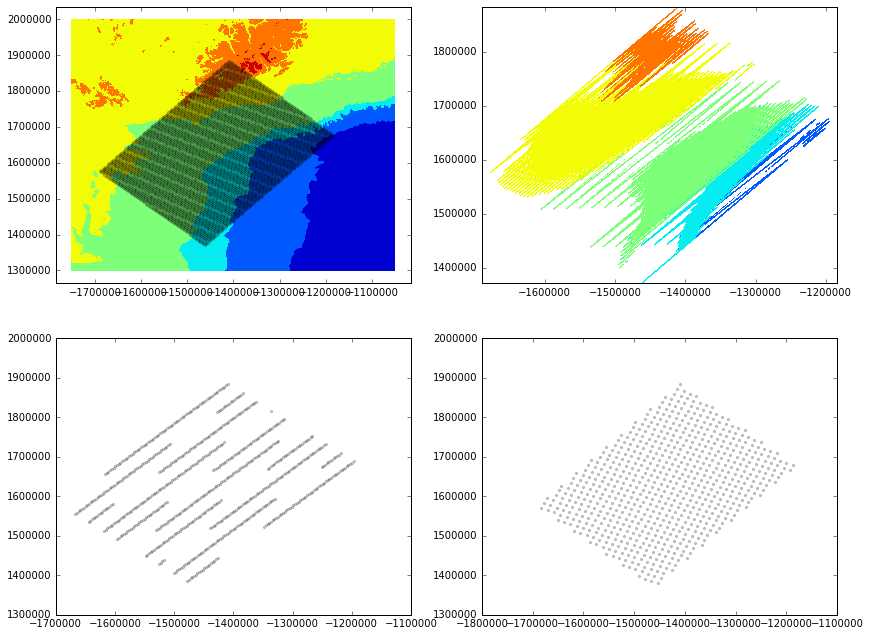

In [59]:
fig, ax = plt.subplots(2,2,figsize=(14,10.9))
levels = [-4000, -3000, -2000, -1000, 0, 1000, 2000, 3000]
ax[0,0].contourf(X_full, Y_full, Z_full, levels)
ax[0,0].scatter(X_sub, Y_sub, c='k', s=5, alpha=0.2)

ax[0,1].contourf(X_sub, Y_sub, Z_sub, levels)

ax[1,0].scatter(X_sub[::10], Y_sub[::10], c='k', s=5, alpha=0.2)

ax[1,1].scatter(lon_s.ravel()[::10], lat_s.ravel()[::10], c='k', s=5, alpha=0.2)

In [91]:
X_full, Y_full = np.meshgrid(xn, yn)
Z_full = zn
# ----------------------------------
x_full = X_full.ravel()
y_full = Y_full.ravel()
z_full = Z_full.ravel()
# ----------------------------------
x_sub = lon_s.ravel()
y_sub = lat_s.ravel()
X_sub, Y_sub = np.meshgrid(x_sub, y_sub)
# ----------------------------------
Z_sub = griddata((x_full, y_full), z_full, (X_sub, Y_sub), method='nearest')

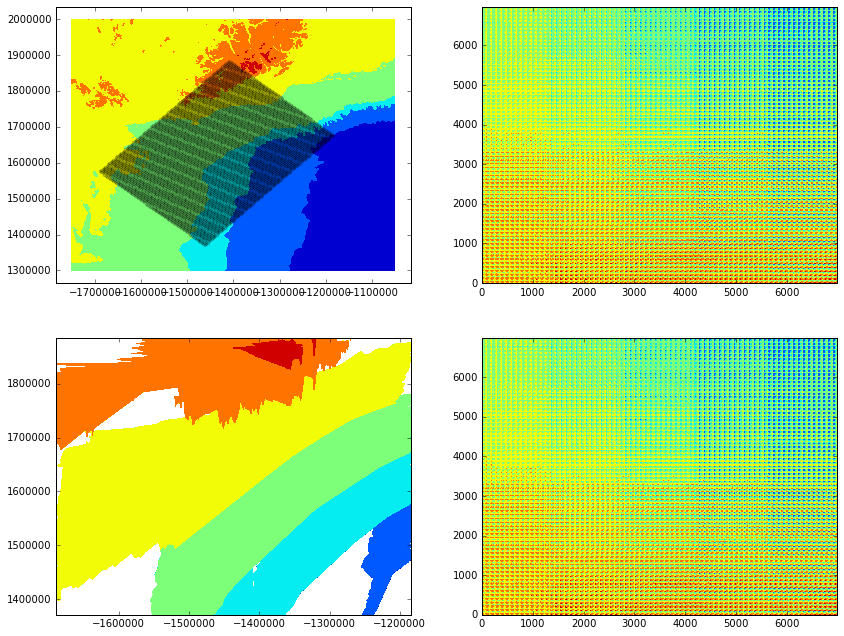

In [105]:
fig, ax = plt.subplots(2,2,figsize=(14,10.9))
levels = [-4000, -3000, -2000, -1000, 0, 1000, 2000, 3000]
ax[0,0].contourf(X_full, Y_full, Z_full, levels)
ax[0,0].scatter(x_sub, y_sub, c='k', s=5, alpha=0.2)

ax[0,1].contourf(Z_sub)
ax[1,0].contourf(x_sub, y_sub, Z_sub, levels)
ax[1,1].contourf(np.arange(x_sub.shape[0]), np.arange(y_sub.shape[0]), Z_sub, levels)

In [106]:
Z_sub = griddata((x_full, y_full), z_full, (X_sub, Y_sub), method='cubic')

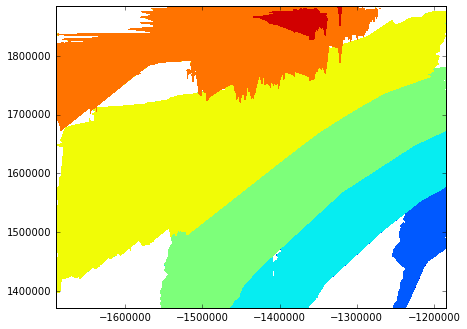

In [107]:
fig, ax = plt.subplots(1,1,figsize=(7,5.4))
ax.contourf(x_sub, y_sub, Z_sub, levels)

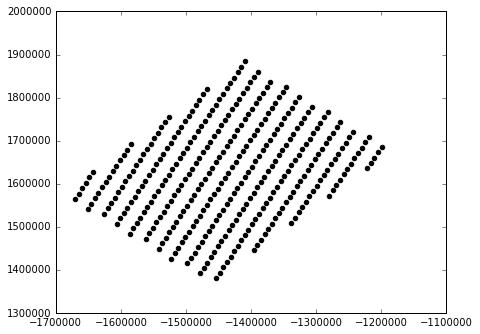

In [111]:
fig, ax = plt.subplots(1,1,figsize=(7,5.4))
ax.scatter(x_sub[::20], y_sub[::20], c = 'k')